Nombre del equipo: Manchester United Football Club y su id: 985 

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mejores parámetros encontrados: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'MultiClass'}
Accuracy en validación con los mejores hiperparámetros: 0.67

Predicción para los partidos de Manchester United Football Club a partir de la jornada: 28:
Número de partidos a predecir: 11
Número de predicciones: 11


Resultado predicho: ['V'] para la jornada  28
Derrota de Manchester United Football Club: 15.17%
Empate : 19.99%
Victoria de Manchester United Football Club: 64.84%


Resultado predicho: ['H'] para la jornada  29
Derrota de Manchester United Football Club: 72.28%
Empate : 17.05%
Victoria de Manchester United Football Club: 10.68%


Resultado predicho: ['H'] para la jornada  30
Victoria de Manchester United Football Club: 78.11%
Empate : 18.94%
Derrota de Manchester United Football Club: 2.95%


Resultado predicho: ['V'] para la jorna

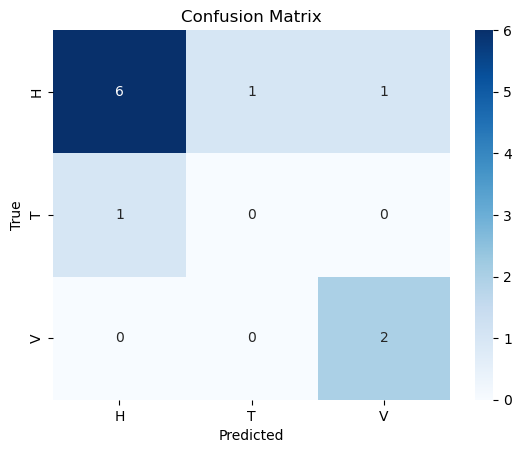

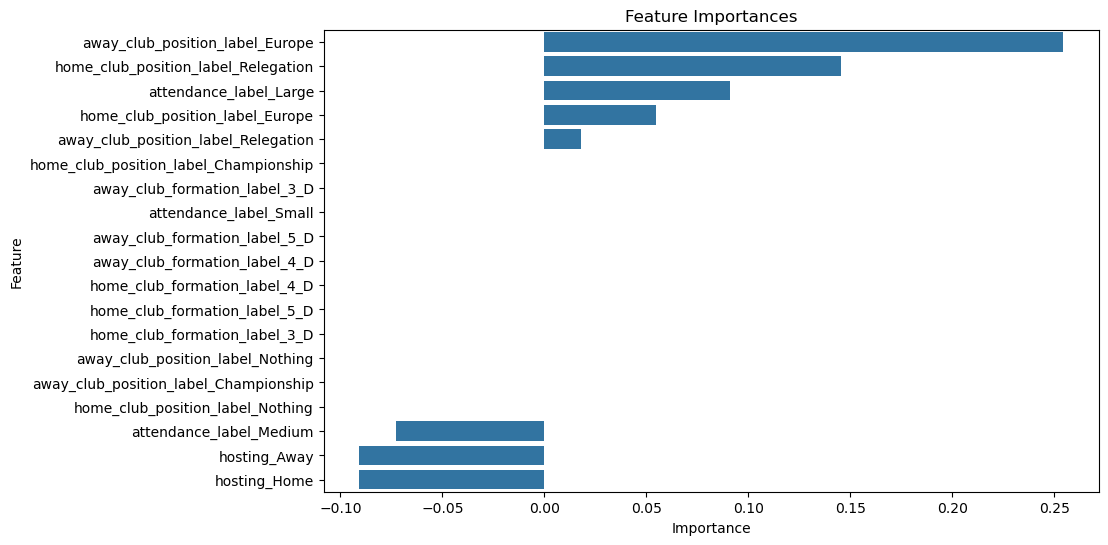

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

def assign_attendance_label(attendance):
    if attendance > 45000:
        return 'Large'
    elif 20000 <= attendance < 45000:
        return 'Medium'
    elif attendance < 20000:
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if formation.startswith('4'):
        return '4_D'
    elif formation.startswith('3'):
        return '3_D'
    elif formation.startswith('5'):
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None

def printer_home(label, proba, team_name):
    if label == 'H':
        print(f"Victoria de {team_name}: {proba:.2f}%")
    elif label == 'T':
        print(f"Empate : {proba:.2f}%")
    else:
        print(f"Derrota de {team_name}: {proba:.2f}%")

def printer_visitor(label, proba, team_name):
    if label == 'V':
        print(f"Victoria de {team_name}: {proba:.2f}%")
    elif label == 'T':
        print(f"Empate : {proba:.2f}%")
    else:
        print(f"Derrota de {team_name}: {proba:.2f}%")

club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')
games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)


season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))
matchDay = 28

filtered_games = games_data[(games_data['season'] == season) & 
                            (games_data['competition_id'] == 'GB1') & 
                            (games_data['competition_type'] == 'domestic_league')].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['round'] == matchDay]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([filtered_games['home_club_name'], filtered_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = filtered_games.loc[filtered_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")

filtered_games['result'] = filtered_games.apply(lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                                                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)

filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)

filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)

team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 'attendance_label',
                   'home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label',
                   'home_club_goals', 'away_club_goals', 'hosting', 'is_win', 'result']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)

features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label','attendance_label','hosting']
train_data = filtered_games[filtered_games['round'] < matchDay]
X_train = train_data[features]
y_train = train_data['result']

test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                           (filtered_games['round'] >= matchDay)][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                                   (filtered_games['round'] >= matchDay)]['result']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(test_data)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=42)

param_grid = {
    'iterations': [100, 200, 500], 
    'learning_rate': [0.01, 0.05, 0.1], 
    'depth': [4, 6, 8],  
    'loss_function': ['MultiClass']  
}

catboost_model = CatBoostClassifier(verbose=0, random_seed=42)

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)


grid_search.fit(X_train_split, y_train_split)

print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

best_model = grid_search.best_estimator_


y_val_pred = best_model.predict(X_val_split)
val_accuracy = accuracy_score(y_val_split, y_val_pred)
print(f"Accuracy en validación con los mejores hiperparámetros: {val_accuracy:.2f}")

if not test_data.empty:
    y_pred = best_model.predict(X_test_encoded)
    y_proba = best_model.predict_proba(X_test_encoded)

    print(f"\nPredicción para los partidos de {team_name} a partir de la jornada: {matchDay}:")
    print(f"Número de partidos a predecir: {len(test_data)}")
    print(f"Número de predicciones: {len(y_pred)}")

    for idx in range(len(test_data)):
        row = test_data.iloc[idx]
        print('\n')
        print("Resultado predicho:", y_pred[idx], "para la jornada ", matchDay + idx)

        class_labels = best_model.classes_
        proba_percentages = y_proba[idx] * 100

        for label, proba in zip(class_labels, proba_percentages):
            if row['hosting'] == 'Home':
                printer_home(label, proba, team_name)
            elif row['hosting'] == 'Away':
                printer_visitor(label, proba, team_name)
            else:
                print('Fallo en la detección del local')

    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(test_data_result, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(test_data_result, y_pred):.2f}")

    cm = confusion_matrix(test_data_result, y_pred, labels=best_model.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    permutation_importances = permutation_importance(best_model, X_test_encoded, test_data_result, scoring="accuracy")
    importances_df = pd.DataFrame({
        "Feature": encoder.get_feature_names_out(features),
        "Importance": permutation_importances.importances_mean
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importances_df)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances")
    plt.show()

else:
    print("No se encontró información para el equipo seleccionado.")

Nombre del equipo: Manchester United Football Club y su id: 985 

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mejores parámetros encontrados: {'depth': 4, 'iterations': 100, 'learning_rate': 0.05, 'loss_function': 'MultiClass'}
Accuracy en validación con los mejores hiperparámetros: 0.57

Predicción para los partidos de Manchester United Football Club en la temporada: 2022:
Número de partidos a predecir: 38
Número de predicciones: 38


Resultado predicho: ['T'] para la jornada  1
Victoria de Manchester United Football Club: 30.46%
Empate : 38.82%
Derrota de Manchester United Football Club: 30.73%


Resultado predicho: ['H'] para la jornada  2
Derrota de Manchester United Football Club: 74.11%
Empate : 15.81%
Victoria de Manchester United Football Club: 10.07%


Resultado predicho: ['H'] para la jornada  3
Victoria de Manchester United Football Club: 61.12%
Empate : 26.21%
Derrota de Manchester United Football Club: 12.68%


Resultado predicho: ['V'] para la jornada  4


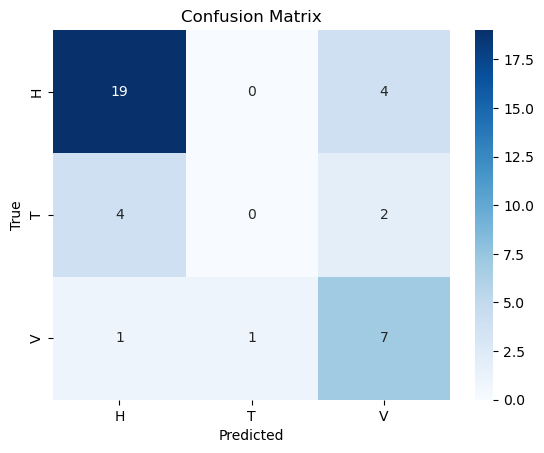

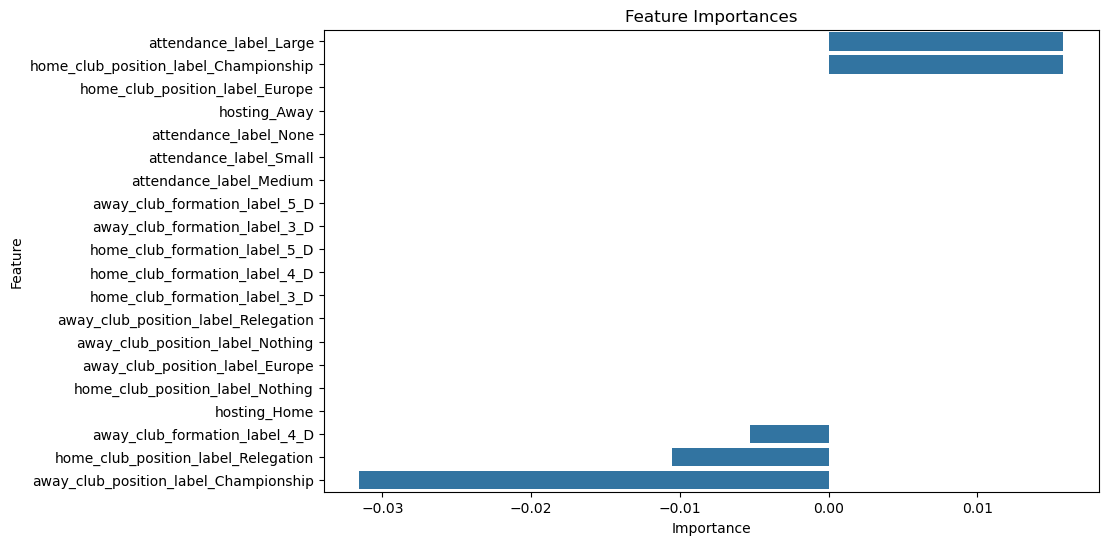

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

def assign_attendance_label(attendance):
    if attendance > 45000:
        return 'Large'
    elif 20000 <= attendance < 45000:
        return 'Medium'
    elif attendance < 20000:
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if formation.startswith('4'):
        return '4_D'
    elif formation.startswith('3'):
        return '3_D'
    elif formation.startswith('5'):
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None

def printer_home(label, proba, team_name):
    if label == 'H':
        print(f"Victoria de {team_name}: {proba:.2f}%")
    elif label == 'T':
        print(f"Empate : {proba:.2f}%")
    else:
        print(f"Derrota de {team_name}: {proba:.2f}%")

def printer_visitor(label, proba, team_name):
    if label == 'V':
        print(f"Victoria de {team_name}: {proba:.2f}%")
    elif label == 'T':
        print(f"Empate : {proba:.2f}%")
    else:
        print(f"Derrota de {team_name}: {proba:.2f}%")

club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')
games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)


season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))

filtered_games = games_data[(games_data['season'] >= 2019) & 
                            (games_data['competition_id'] == 'GB1') & 
                            (games_data['competition_type'] == 'domestic_league')].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['season'] == season]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([selected_games['home_club_name'], selected_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = selected_games.loc[selected_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")

filtered_games['result'] = filtered_games.apply(lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                                                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)

filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)

filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)


selected_games = filtered_games[filtered_games['season'] < season]

merged_club_games = club_games_data.merge(club_data, on='club_id')
selected_games = merged_club_games.merge(selected_games, on='game_id')


team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 'attendance_label',
                   'home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label',
                   'home_club_goals', 'away_club_goals', 'hosting', 'is_win', 'result','season']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)

filtered_games = filtered_games[filtered_games['season'] == season]

features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label','attendance_label','hosting']

train_data = selected_games
X_train = train_data[features]
y_train = train_data['result']

test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id))][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id))]['result']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(test_data)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=42)


param_grid = {
    'iterations': [100, 200, 500], 
    'learning_rate': [0.01, 0.05, 0.1],  
    'depth': [4, 6, 8], 
    'loss_function': ['MultiClass'] 
}

catboost_model = CatBoostClassifier(verbose=0, random_seed=42)

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train_split, y_train_split)

print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

y_val_pred = best_model.predict(X_val_split)
val_accuracy = accuracy_score(y_val_split, y_val_pred)
print(f"Accuracy en validación con los mejores hiperparámetros: {val_accuracy:.2f}")

if not test_data.empty:
    y_pred = best_model.predict(X_test_encoded)
    y_proba = best_model.predict_proba(X_test_encoded)

    print(f"\nPredicción para los partidos de {team_name} en la temporada: {season}:")
    print(f"Número de partidos a predecir: {len(test_data)}")
    print(f"Número de predicciones: {len(y_pred)}")

    for idx in range(len(test_data)):
        row = test_data.iloc[idx]
        print('\n')
        print("Resultado predicho:", y_pred[idx], "para la jornada ", idx+1)

        class_labels = best_model.classes_
        proba_percentages = y_proba[idx] * 100

        for label, proba in zip(class_labels, proba_percentages):
            if row['hosting'] == 'Home':
                printer_home(label, proba, team_name)
            elif row['hosting'] == 'Away':
                printer_visitor(label, proba, team_name)
            else:
                print('Fallo en la detección del local')

    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(test_data_result, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(test_data_result, y_pred):.2f}")

    cm = confusion_matrix(test_data_result, y_pred, labels=best_model.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    permutation_importances = permutation_importance(best_model, X_test_encoded, test_data_result, scoring="accuracy")
    importances_df = pd.DataFrame({
        "Feature": encoder.get_feature_names_out(features),
        "Importance": permutation_importances.importances_mean
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importances_df)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances")
    plt.show()

else:
    print("No se encontró información para el equipo seleccionado.")

Nombre del equipo: Manchester United Football Club y su id: 985 

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mejores parámetros encontrados: {'depth': 4, 'iterations': 100, 'learning_rate': 0.01, 'loss_function': 'MultiClass'}
Accuracy en validación con los mejores hiperparámetros: 0.50

Predicción para los partidos de Manchester United Football Club a partir de la jornada: 19:
Número de partidos a predecir: 20
Número de predicciones: 20


Resultado predicho: ['H'] para la jornada  19
Victoria de Manchester United Football Club: 45.46%
Empate : 29.88%
Derrota de Manchester United Football Club: 24.66%


Resultado predicho: ['H'] para la jornada  20
Victoria de Manchester United Football Club: 41.08%
Empate : 33.59%
Derrota de Manchester United Football Club: 25.34%


Resultado predicho: ['T'] para la jornada  21
Derrota de Manchester United Football Club: 32.70%
Empate : 33.96%
Victoria de Manchester United Football Club: 33.35%


Resultado predicho: ['H'] para la jor

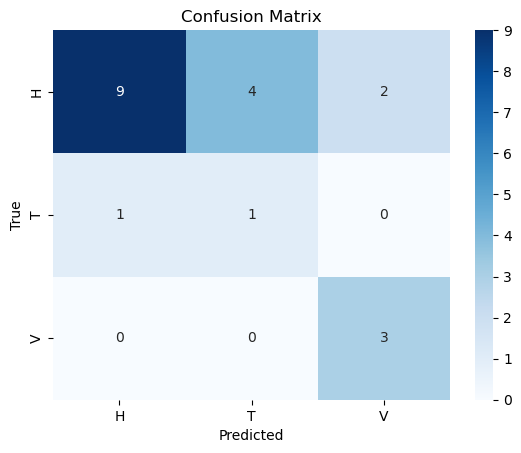

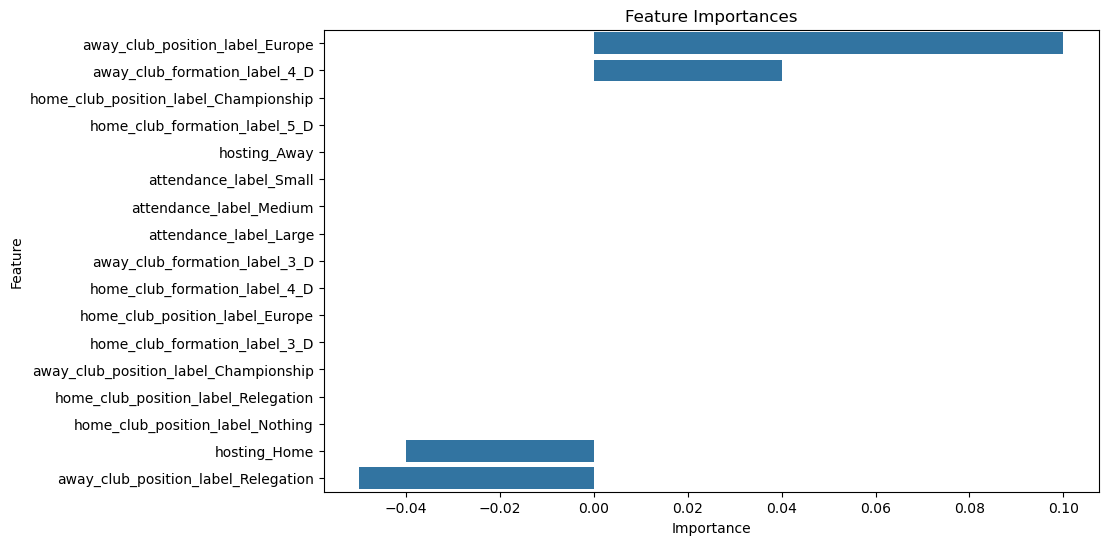

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

def assign_attendance_label(attendance):
    if attendance > 45000:
        return 'Large'
    elif 20000 <= attendance < 45000:
        return 'Medium'
    elif attendance < 20000:
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if formation.startswith('4'):
        return '4_D'
    elif formation.startswith('3'):
        return '3_D'
    elif formation.startswith('5'):
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None

def printer_home(label, proba, team_name):
    if label == 'H':
        print(f"Victoria de {team_name}: {proba:.2f}%")
    elif label == 'T':
        print(f"Empate : {proba:.2f}%")
    else:
        print(f"Derrota de {team_name}: {proba:.2f}%")

def printer_visitor(label, proba, team_name):
    if label == 'V':
        print(f"Victoria de {team_name}: {proba:.2f}%")
    elif label == 'T':
        print(f"Empate : {proba:.2f}%")
    else:
        print(f"Derrota de {team_name}: {proba:.2f}%")

club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')
games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)

season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))
matchDay = 19

filtered_games = games_data[(games_data['season'] == season) & 
                            (games_data['competition_id'] == 'GB1') & 
                            (games_data['competition_type'] == 'domestic_league')].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['round'] == matchDay]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([filtered_games['home_club_name'], filtered_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = filtered_games.loc[filtered_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")

filtered_games['result'] = filtered_games.apply(lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                                                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)

filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)

filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)

team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 'attendance_label',
                   'home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label',
                   'home_club_goals', 'away_club_goals', 'hosting', 'is_win', 'result']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)

features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label','attendance_label','hosting']
train_data = filtered_games[filtered_games['round'] < matchDay]
X_train = train_data[features]
y_train = train_data['result']

test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                           (filtered_games['round'] >= matchDay)][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                                   (filtered_games['round'] >= matchDay)]['result']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(test_data)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=42)

param_grid = {
    'iterations': [100, 200, 500],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'depth': [4, 6, 8], 
    'loss_function': ['MultiClass']  
}

catboost_model = CatBoostClassifier(verbose=0, random_seed=42)

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train_split, y_train_split)

print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

y_val_pred = best_model.predict(X_val_split)
val_accuracy = accuracy_score(y_val_split, y_val_pred)
print(f"Accuracy en validación con los mejores hiperparámetros: {val_accuracy:.2f}")

if not test_data.empty:
    y_pred = best_model.predict(X_test_encoded)
    y_proba = best_model.predict_proba(X_test_encoded)

    print(f"\nPredicción para los partidos de {team_name} a partir de la jornada: {matchDay}:")
    print(f"Número de partidos a predecir: {len(test_data)}")
    print(f"Número de predicciones: {len(y_pred)}")

    for idx in range(len(test_data)):
        row = test_data.iloc[idx]
        print('\n')
        print("Resultado predicho:", y_pred[idx], "para la jornada ", matchDay + idx)

        class_labels = best_model.classes_
        proba_percentages = y_proba[idx] * 100

        for label, proba in zip(class_labels, proba_percentages):
            if row['hosting'] == 'Home':
                printer_home(label, proba, team_name)
            elif row['hosting'] == 'Away':
                printer_visitor(label, proba, team_name)
            else:
                print('Fallo en la detección del local')

    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(test_data_result, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(test_data_result, y_pred):.2f}")

    cm = confusion_matrix(test_data_result, y_pred, labels=best_model.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    permutation_importances = permutation_importance(best_model, X_test_encoded, test_data_result, scoring="accuracy")
    importances_df = pd.DataFrame({
        "Feature": encoder.get_feature_names_out(features),
        "Importance": permutation_importances.importances_mean
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importances_df)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances")
    plt.show()

else:
    print("No se encontró información para el equipo seleccionado.")